In [2]:
# useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [8]:
# import scripts
from proj1_helpers import *
from classifiers import *
from solver import *
from dataprocessing import *
from implementations import *

## Open data

In [4]:
# fetch train data
DATA_TRAIN_PATH = '../data/train.csv'
y, tX, ids, features = load_csv_data(DATA_TRAIN_PATH, sub_sample=False)
X = tX

In [12]:
len(features)

32

In [6]:
def split_data(X, y=None):
    """
    Splits the data matrix X into partitions based on the integer feature 'PRI_jet_num'
    
    :param X: examples
    :param y: labels
    :return indices of split for every subset, X_split, y_split
    """
    # features
    undef_feature_for = {
        'DER_deltaeta_jet_jet'   : [0, 1],
        'DER_mass_jet_jet'       : [0, 1],
        'DER_prodeta_jet_jet'    : [0, 1],
        'DER_lep_eta_centrality' : [0, 1],
        'PRI_jet_num'            : [0, 1, 2, 3],
        'PRI_jet_leading_pt'     : [0],
        'PRI_jet_leading_eta'    : [0],
        'PRI_jet_leading_phi'    : [0],
        'PRI_jet_subleading_pt'  : [0, 1],
        'PRI_jet_subleading_eta' : [0, 1],
        'PRI_jet_subleading_phi' : [0, 1],
        'PRI_jet_all_pt'         : [0]
    }

    # the feature based on which we split tX
    jet_num_feature = "PRI_jet_num"
    jet_levels = 4

    # build valid features for every subset of tX
    features_split = []
    for jet in range(jet_levels):
        valid_features = [ f for f in features if not ((f in undef_feature_for) and (jet in undef_feature_for[f])) ]
        features_split.append(valid_features)
        
    # split data based on jet level (vertical split)
    split_indices = [
        X[:,features.index(jet_num_feature)] == i for i in range(jet_levels)
    ]
    X_split = [
        X[X[:,features.index(jet_num_feature)] == i,:] for i in range(jet_levels)
    ]
    if y is None:
        y_split = None
    else:
        y_split = [
            y[X[:,features.index(jet_num_feature)] == i] for i in range(jet_levels)
        ]

    # only keep relevant features (horizontal split)
    for i, X_ in enumerate(X_split):
        indices = [ features.index(feature) for feature in features_split[i] ]
        indices_bool = [ e in indices for e in range(len(features)) ]
        X_split[i] = X_[:,indices_bool]
        
    return split_indices, X_split, y_split

## Feature engineering

In [10]:
# additive binarization of NaN values
feats_binarization = ['DER_mass_mmc','DER_deltaeta_jet_jet','PRI_jet_leading_pt']

# removing unnecessary features
feats_removal = ['DER_deltaeta_jet_jet','DER_mass_jet_jet','DER_prodeta_jet_jet','DER_lep_eta_centrality',
                 'PRI_jet_leading_pt','PRI_jet_leading_eta','PRI_jet_leading_phi','PRI_jet_subleading_pt',
                 'PRI_jet_subleading_eta','PRI_jet_subleading_phi']

### Handling case by case

In [11]:
# handling case A
X_A = X.copy()

# handling case B
X_B = X.copy()
X_B, mean_B, std_B = standardize(X_B)
X_B = np.c_[np.ones(len(y)), X_B]

# handling case C
X_C = X.copy()
X_C = replace_NaN_by_median(X_C)
X_C, mean_C, std_C = standardize(X_C)
X_C = np.c_[np.ones(len(y)), X_C]

# handling case D
X_D = X.copy()
X_D, features_D = binarize_undefined(X_D, features, feats_binarization)
X_D, features_D = remove_features(X_D, features_D, feats_removal)
X_D = replace_NaN_by_median(X_D) # only for DER_mass_mmc
X_D, mean_D, std_D = standardize(X_D)
X_D = np.c_[np.ones(len(y)), X_D]

# handling case E
# in this model, if 'DER_mass_mmc' (first feature) is NaN, we predict background
X_E = X.copy()
X_E, _ = remove_features(X_E, features, feats_removal)
#X_E, mean_E, std_E = standardize(X_E)
X_E = np.c_[np.ones(len(y)), X_E]

# handling case F
X_F = X.copy()
indices_split, X_split, y_split = split_data(X_F, y)

# handling case G
X_G = X.copy()

IndexError: boolean index did not match indexed array along dimension 1; dimension is 30 but corresponding boolean dimension is 32

## Fit and predict

* A - base
* B - base + offset + standardisation
* C - base + offset + standardisation + NaN to median
* D - base + offset + standardisation + additive binarization + removal of 10 NaN values + median for DER_mass_mmc
* E - C or D + decision tree
* F - E + feature augmentation (L2 Kernels)
* G - E + feature augmentation (L1 polynomial manually coded)

In [17]:
# choice of classifier
classifier = LogisticRegression(max_evaluations=300, verbose=True)
classifier_E = LogisticRegressionDecisionTree(1, verbose=True)

ratio = 0.8
k = 2
    
accuracy_A = cross_validate_kfold(y, X_A, classifier, k)
accuracy_B = cross_validate_kfold(y, X_B, classifier, k)
accuracy_C = cross_validate_kfold(y, X_C, classifier, k)
accuracy_D = cross_validate_kfold(y, X_D, classifier, k)
accuracy_E = cross_validate_kfold(y, X_B, classifier_E, k)
accuracy_F = cross_validate_kfold(y, X_F, classifier, k)
accuracy_G = cross_validate_kfold(y, X_G, classifier, k)

accuracy = [accuracy_A, accuracy_B, accuracy_C, accuracy_D,
            accuracy_E, accuracy_F, accuracy_G]

f_new: 3902998170329571.000 - f: 86643.398 - Backtracking...
f_new: 804151728303285.375 - f: 86643.398 - Backtracking...
f_new: 165682886320974.281 - f: 86643.398 - Backtracking...
f_new: 34136367379660.523 - f: 86643.398 - Backtracking...
f_new: 7033264600438.548 - f: 86643.398 - Backtracking...
f_new: 1449094177891.802 - f: 86643.398 - Backtracking...
f_new: 298563201344.288 - f: 86643.398 - Backtracking...
f_new: 61514288465.360 - f: 86643.398 - Backtracking...
f_new: 12674067521.728 - f: 86643.398 - Backtracking...
f_new: 2611303880.062 - f: 86643.398 - Backtracking...
f_new: 538028818.901 - f: 86643.398 - Backtracking...
f_new: 110862924.666 - f: 86643.398 - Backtracking...
f_new: 22852100.999 - f: 86643.398 - Backtracking...
f_new: 4719768.566 - f: 86643.398 - Backtracking...
f_new: 991328.815 - f: 86643.398 - Backtracking...
f_new: 231204.703 - f: 86643.398 - Backtracking...
f_new: 88497.183 - f: 86643.398 - Backtracking...
18 - loss: 78721.926
19 - loss: 78482.144
20 - loss: 78

f_new: 584062105.331 - f: 86643.398 - Backtracking...
f_new: 121247221.633 - f: 86643.398 - Backtracking...
f_new: 25178445.788 - f: 86643.398 - Backtracking...
f_new: 5237703.534 - f: 86643.398 - Backtracking...
f_new: 1105344.852 - f: 86643.398 - Backtracking...
f_new: 255904.269 - f: 86643.398 - Backtracking...
f_new: 91701.142 - f: 86643.398 - Backtracking...
18 - loss: 78627.875
19 - loss: 78342.924
20 - loss: 78161.427
21 - loss: 77820.536
22 - loss: 75970.038
f_new: 77158.985 - f: 75970.038 - Backtracking...
24 - loss: 75829.283
25 - loss: 75697.053
26 - loss: 75652.617
27 - loss: 75573.243
28 - loss: 74745.751
29 - loss: 74316.962
f_new: 74645.856 - f: 74316.962 - Backtracking...
31 - loss: 74274.492
32 - loss: 74242.891
33 - loss: 74228.272
34 - loss: 74197.430
35 - loss: 74064.062
36 - loss: 73948.964
37 - loss: 73917.393
38 - loss: 73897.359
39 - loss: 73889.734
40 - loss: 73868.794
41 - loss: 72997.140
f_new: 73111.641 - f: 72997.140 - Backtracking...
43 - loss: 72871.173
4

53 - loss: 62149.484
54 - loss: 62149.396
55 - loss: 62149.329
56 - loss: 62149.238
57 - loss: 62141.605
f_new: 62149.125 - f: 62141.605 - Backtracking...
59 - loss: 62141.526
60 - loss: 62141.460
61 - loss: 62141.452
62 - loss: 62141.446
63 - loss: 62141.396
64 - loss: 62141.344
65 - loss: 62141.259
66 - loss: 62141.175
67 - loss: 62141.167
68 - loss: 62141.148
69 - loss: 62141.144
70 - loss: 62141.141
71 - loss: 62141.037
72 - loss: 62140.959
73 - loss: 62140.916
74 - loss: 62140.906
75 - loss: 62140.899
76 - loss: 62140.897
77 - loss: 62140.895
78 - loss: 62140.890
79 - loss: 62140.631
f_new: 62141.394 - f: 62140.631 - Backtracking...
81 - loss: 62140.630
82 - loss: 62140.629
83 - loss: 62140.629
84 - loss: 62140.629
85 - loss: 62140.624
86 - loss: 62140.622
87 - loss: 62140.620
88 - loss: 62140.619
89 - loss: 62140.619
90 - loss: 62140.619
91 - loss: 62140.619
92 - loss: 62140.618
93 - loss: 62140.613
f_new: 62140.615 - f: 62140.613 - Backtracking...
95 - loss: 62140.612
f_new: 621

107 - loss: 62221.693
108 - loss: 62221.693
109 - loss: 62221.683
110 - loss: 62221.680
111 - loss: 62221.678
112 - loss: 62221.674
113 - loss: 62221.673
114 - loss: 62221.673
115 - loss: 62221.673
116 - loss: 62221.673
117 - loss: 62221.673
118 - loss: 62221.673
119 - loss: 62221.672
120 - loss: 62221.672
121 - loss: 62221.660
f_new: 62221.662 - f: 62221.660 - Backtracking...
123 - loss: 62221.660
124 - loss: 62221.660
125 - loss: 62221.660
126 - loss: 62221.659
127 - loss: 62221.656
128 - loss: 62221.653
129 - loss: 62221.652
130 - loss: 62221.652
131 - loss: 62221.652
132 - loss: 62221.652
133 - loss: 62221.652
134 - loss: 62221.649
135 - loss: 62221.645
136 - loss: 62221.644
137 - loss: 62221.644
138 - loss: 62221.644
139 - loss: 62221.644
140 - loss: 62221.644
141 - loss: 62221.644
142 - loss: 62221.643
143 - loss: 62221.642
144 - loss: 62221.642
145 - loss: 62221.642
146 - loss: 62221.642
147 - loss: 62221.641
148 - loss: 62221.641
149 - loss: 62221.639
150 - loss: 62221.635
151 

160 - loss: 70998.103
161 - loss: 70997.133
162 - loss: 70997.056
163 - loss: 70997.033
164 - loss: 70997.020
165 - loss: 70997.012
166 - loss: 70997.006
167 - loss: 70997.001
168 - loss: 70996.977
169 - loss: 70996.929
170 - loss: 70996.876
171 - loss: 70996.858
172 - loss: 70996.845
173 - loss: 70996.829
174 - loss: 70996.463
175 - loss: 70996.303
176 - loss: 70996.293
177 - loss: 70996.288
178 - loss: 70996.278
179 - loss: 70996.262
180 - loss: 70996.201
181 - loss: 70995.649
182 - loss: 70995.598
183 - loss: 70995.585
184 - loss: 70995.572
185 - loss: 70995.563
186 - loss: 70995.555
187 - loss: 70995.542
188 - loss: 70995.487
189 - loss: 70995.451
190 - loss: 70995.445
191 - loss: 70995.439
192 - loss: 70995.430
193 - loss: 70959.775
f_new: 71168.027 - f: 70959.775 - Backtracking...
195 - loss: 70958.358
196 - loss: 70957.145
197 - loss: 70957.113
198 - loss: 70957.098
199 - loss: 70957.077
200 - loss: 70957.056
201 - loss: 70956.971
202 - loss: 70956.892
203 - loss: 70956.880
204 

226 - loss: 71028.982
227 - loss: 71028.977
228 - loss: 71028.972
229 - loss: 71028.914
230 - loss: 71028.846
231 - loss: 71028.831
232 - loss: 71028.819
233 - loss: 71028.807
234 - loss: 71028.496
235 - loss: 71028.339
236 - loss: 71028.331
237 - loss: 71028.325
238 - loss: 71028.319
239 - loss: 71027.789
240 - loss: 71026.239
241 - loss: 71026.203
242 - loss: 71026.191
243 - loss: 71026.179
244 - loss: 71026.154
245 - loss: 71026.139
246 - loss: 71026.133
247 - loss: 71026.128
248 - loss: 71026.113
249 - loss: 71026.035
250 - loss: 71025.955
251 - loss: 71025.945
252 - loss: 71025.940
253 - loss: 71025.934
254 - loss: 71024.420
255 - loss: 70971.774
f_new: 71032.753 - f: 70971.774 - Backtracking...
257 - loss: 70971.525
258 - loss: 70971.352
259 - loss: 70971.285
260 - loss: 70971.187
261 - loss: 70970.759
262 - loss: 70970.716
263 - loss: 70970.678
264 - loss: 70970.673
265 - loss: 70970.669
266 - loss: 70970.643
267 - loss: 70970.602
268 - loss: 70970.585
269 - loss: 70970.575
270 

297 - loss: 65966.786
298 - loss: 65966.592
299 - loss: 65966.537
300 - loss: 65966.489
Reached maximum number of function evaluations 300
f_new: 4699509650.235 - f: 86643.398 - Backtracking...
f_new: 1144019973.992 - f: 86643.398 - Backtracking...
f_new: 278501441.972 - f: 86643.398 - Backtracking...
f_new: 67806910.544 - f: 86643.398 - Backtracking...
f_new: 16517324.545 - f: 86643.398 - Backtracking...
f_new: 4032317.486 - f: 86643.398 - Backtracking...
f_new: 995123.626 - f: 86643.398 - Backtracking...
f_new: 263321.768 - f: 86643.398 - Backtracking...
f_new: 104510.743 - f: 86643.398 - Backtracking...
10 - loss: 81100.259
11 - loss: 75146.808
12 - loss: 72905.939
13 - loss: 71730.783
14 - loss: 70781.305
15 - loss: 69130.380
16 - loss: 68133.659
17 - loss: 68092.667
18 - loss: 67752.477
19 - loss: 67705.259
20 - loss: 67657.019
21 - loss: 67411.518
22 - loss: 67295.423
23 - loss: 67245.107
24 - loss: 67224.542
25 - loss: 67217.455
26 - loss: 67199.010
27 - loss: 67035.460
28 - los

35 - loss: 62499.031
36 - loss: 62494.923
37 - loss: 62161.780
f_new: 64194.506 - f: 62161.780 - Backtracking...
39 - loss: 62161.178
40 - loss: 62160.684
41 - loss: 62160.471
42 - loss: 62160.060
43 - loss: 62157.945
44 - loss: 62155.911
45 - loss: 62155.143
46 - loss: 62154.580
47 - loss: 62154.464
48 - loss: 62154.344
49 - loss: 62152.702
50 - loss: 62150.826
51 - loss: 62150.177
52 - loss: 62149.788
53 - loss: 62149.484
54 - loss: 62149.396
55 - loss: 62149.329
56 - loss: 62149.238
57 - loss: 62141.605
f_new: 62149.125 - f: 62141.605 - Backtracking...
59 - loss: 62141.526
60 - loss: 62141.460
61 - loss: 62141.452
62 - loss: 62141.446
63 - loss: 62141.396
64 - loss: 62141.344
65 - loss: 62141.259
66 - loss: 62141.175
67 - loss: 62141.167
68 - loss: 62141.148
69 - loss: 62141.144
70 - loss: 62141.141
71 - loss: 62141.037
72 - loss: 62140.959
73 - loss: 62140.916
74 - loss: 62140.906
75 - loss: 62140.899
76 - loss: 62140.897
77 - loss: 62140.895
78 - loss: 62140.890
79 - loss: 62140.6

158 - loss: 66361.291
159 - loss: 66361.157
160 - loss: 66360.967
161 - loss: 66358.452
162 - loss: 66355.696
163 - loss: 66352.305
164 - loss: 66351.261
165 - loss: 66351.089
166 - loss: 66350.958
167 - loss: 66350.759
168 - loss: 66324.584
169 - loss: 66297.103
170 - loss: 66291.011
f_new: 66297.770 - f: 66291.011 - Backtracking...
172 - loss: 66290.718
173 - loss: 66290.564
174 - loss: 66290.438
175 - loss: 66289.006
176 - loss: 66287.577
177 - loss: 66279.182
178 - loss: 66277.156
179 - loss: 66276.285
180 - loss: 66276.168
181 - loss: 66276.003
182 - loss: 66222.738
183 - loss: 66204.044
184 - loss: 66168.906
f_new: 66252.175 - f: 66168.906 - Backtracking...
186 - loss: 66164.692
187 - loss: 66164.449
188 - loss: 66163.862
189 - loss: 66161.598
190 - loss: 66159.761
191 - loss: 66158.814
192 - loss: 66158.123
193 - loss: 66158.020
194 - loss: 66157.914
195 - loss: 66153.441
196 - loss: 66149.096
197 - loss: 66147.131
198 - loss: 66146.853
199 - loss: 66146.726
200 - loss: 66146.63

183 - loss: 66642.041
184 - loss: 66634.848
185 - loss: 66633.829
186 - loss: 66633.560
187 - loss: 66633.411
188 - loss: 66632.794
189 - loss: 66594.484
190 - loss: 66535.302
191 - loss: 66516.146
f_new: 66549.035 - f: 66516.146 - Backtracking...
193 - loss: 66508.809
194 - loss: 66508.661
195 - loss: 66507.933
196 - loss: 66506.530
197 - loss: 66505.144
198 - loss: 66504.932
199 - loss: 66504.808
200 - loss: 66504.683
201 - loss: 66471.538
202 - loss: 65963.736
f_new: 68089.564 - f: 65963.736 - Backtracking...
204 - loss: 65927.906
205 - loss: 65927.766
206 - loss: 65927.695
207 - loss: 65926.881
208 - loss: 65926.073
209 - loss: 65924.527
210 - loss: 65924.481
211 - loss: 65924.256
212 - loss: 65924.226
213 - loss: 65923.693
214 - loss: 65923.137
215 - loss: 65922.500
216 - loss: 65922.042
217 - loss: 65921.989
218 - loss: 65921.962
219 - loss: 65921.936
220 - loss: 65921.275
221 - loss: 65920.561
222 - loss: 65920.088
223 - loss: 65919.743
224 - loss: 65919.666
225 - loss: 65919.64

218 - loss: 65669.564
219 - loss: 65669.533
220 - loss: 65669.504
221 - loss: 65668.738
222 - loss: 65667.965
223 - loss: 65667.561
224 - loss: 65667.392
225 - loss: 65667.334
226 - loss: 65667.309
227 - loss: 65667.279
228 - loss: 65666.221
229 - loss: 65665.068
230 - loss: 65664.732
231 - loss: 65664.466
232 - loss: 65664.430
233 - loss: 65664.406
234 - loss: 65664.382
235 - loss: 65652.250
236 - loss: 65639.150
f_new: 65653.239 - f: 65639.150 - Backtracking...
238 - loss: 65639.071
239 - loss: 65639.001
240 - loss: 65638.970
241 - loss: 65638.839
242 - loss: 65638.294
243 - loss: 65637.572
244 - loss: 65637.225
245 - loss: 65637.048
246 - loss: 65637.023
247 - loss: 65637.000
248 - loss: 65636.625
249 - loss: 65636.236
250 - loss: 65635.611
251 - loss: 65634.698
252 - loss: 65634.643
253 - loss: 65634.613
254 - loss: 65634.591
255 - loss: 65634.371
256 - loss: 65634.091
257 - loss: 65631.888
258 - loss: 65627.464
259 - loss: 65627.289
260 - loss: 65627.265
261 - loss: 65627.243
262 

247 - loss: 65893.661
248 - loss: 65690.515
f_new: 95742.458 - f: 65690.515 - Backtracking...
250 - loss: 65690.411
251 - loss: 65690.156
252 - loss: 65690.141
253 - loss: 65690.127
254 - loss: 65688.941
255 - loss: 65687.858
256 - loss: 65687.802
257 - loss: 65687.741
258 - loss: 65687.729
259 - loss: 65687.717
260 - loss: 65687.464
261 - loss: 65687.185
262 - loss: 65686.916
263 - loss: 65686.703
264 - loss: 65686.671
265 - loss: 65686.659
266 - loss: 65686.647
267 - loss: 65686.410
268 - loss: 65685.952
269 - loss: 65685.435
270 - loss: 65685.278
271 - loss: 65685.261
272 - loss: 65685.249
273 - loss: 65685.238
274 - loss: 65685.016
275 - loss: 65684.774
276 - loss: 65684.467
277 - loss: 65684.148
278 - loss: 65683.943
279 - loss: 65683.917
280 - loss: 65683.906
281 - loss: 65683.894
282 - loss: 65683.662
283 - loss: 65683.364
284 - loss: 65683.022
285 - loss: 65682.806
286 - loss: 65682.787
287 - loss: 65682.776
288 - loss: 65682.765
289 - loss: 65682.553
290 - loss: 65682.318
291 

In [7]:
y_E = y[X_E[:,1] != -999]
X_L = X_E[X_E[:,1] != -999,:]
standard,_,_ = standardize(X_L[:,1:])
X_S = np.c_[np.ones(len(y_E)), standard]
y_eval = np.r_[y_E, y[X_E[:,1] == -999]]
X_eval = np.r_[X_S, X_E[X_E[:,1] == -999,:]]

In [19]:
classifier_E = LogisticRegressionDecisionTree(1, max_evaluations=500, verbose=True)
classifier_E.fit(y, X_B)
print(np.mean(y == classifier_E.predict(X_B)))

f_new: 19313250287.196 - f: 173286.795 - Backtracking...
f_new: 3560749515.413 - f: 173286.795 - Backtracking...
f_new: 656505503.556 - f: 173286.795 - Backtracking...
f_new: 121058314.990 - f: 173286.795 - Backtracking...
f_new: 22339811.934 - f: 173286.795 - Backtracking...
f_new: 4141434.961 - f: 173286.795 - Backtracking...
f_new: 795610.194 - f: 173286.795 - Backtracking...
f_new: 214357.603 - f: 173286.795 - Backtracking...
9 - loss: 161084.657
10 - loss: 151529.865
11 - loss: 148472.865
12 - loss: 138372.653
13 - loss: 133979.090
f_new: 134893.075 - f: 133979.090 - Backtracking...
15 - loss: 133239.140
16 - loss: 133005.515
17 - loss: 132788.523
18 - loss: 130136.375
19 - loss: 128555.432
20 - loss: 127678.635
21 - loss: 127320.604
f_new: 127332.435 - f: 127320.604 - Backtracking...
23 - loss: 127199.690
24 - loss: 127157.984
25 - loss: 127120.351
26 - loss: 126889.693
27 - loss: 126643.050
28 - loss: 126206.636
29 - loss: 126038.285
30 - loss: 125888.537
31 - loss: 125855.641
3

339 - loss: 124366.342
340 - loss: 124366.342
341 - loss: 124366.342
342 - loss: 124366.341
343 - loss: 124366.341
344 - loss: 124366.341
345 - loss: 124366.341
346 - loss: 124366.341
347 - loss: 124366.341
348 - loss: 124366.341
349 - loss: 124366.340
350 - loss: 124366.339
351 - loss: 124366.339
352 - loss: 124366.338
353 - loss: 124366.338
354 - loss: 124366.338
355 - loss: 124366.338
356 - loss: 124366.338
357 - loss: 124366.336
358 - loss: 124366.331
359 - loss: 124366.331
360 - loss: 124366.331
361 - loss: 124366.331
362 - loss: 124366.331
363 - loss: 124366.331
364 - loss: 124366.331
365 - loss: 124366.330
366 - loss: 124366.330
367 - loss: 124366.330
368 - loss: 124366.330
369 - loss: 124366.330
370 - loss: 124366.330
371 - loss: 124366.329
372 - loss: 124366.321
373 - loss: 124366.319
374 - loss: 124366.319
375 - loss: 124366.319
376 - loss: 124366.319
377 - loss: 124366.319
378 - loss: 124366.319
379 - loss: 124366.319
380 - loss: 124366.319
381 - loss: 124366.319
382 - loss:

### Boxplot visualisation

{'whiskers': [<matplotlib.lines.Line2D at 0x1fff29b2390>,
 'caps': [<matplotlib.lines.Line2D at 0x1fff29b2a20>,
 'boxes': [<matplotlib.lines.Line2D at 0x1fff29a8f60>,
 'medians': [<matplotlib.lines.Line2D at 0x1fff29b2e48>,
 'fliers': [<matplotlib.lines.Line2D at 0x1fff29bd470>,
 'means': []}

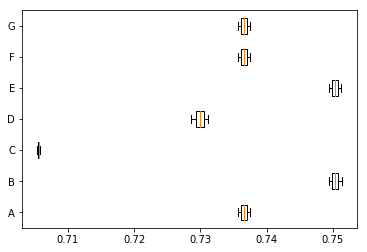

In [20]:
plt.boxplot(accuracy, vert=False, labels=['A','B','C','D','E','F','G'])